In [1]:
import pandas as pd
import numpy as np
import string

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as pp
from os import listdir
from numpy import array
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [2]:
####---------------------------DATA MANIPULATION ---------------------------------####
#load the currencies files
path='data/'
CurrenciesFilesPath = ['data/'+f for f in listdir(path) if isfile(join(path, f))]
for file in CurrenciesFilesPath:
    print(file)

data/BCH-USD.csv
data/BTC-USD.csv
data/ETH-USD.csv
data/IOT-USD.csv
data/LTC-USD.csv
data/XMR-USD.csv
data/XRP-USD.csv


In [3]:
#now the idea is to put all these data together in a single variable, matching them with the date variable
data=[pd.read_csv(f, index_col='Date', parse_dates=['Date'], converters={'Close':np.float32}) for f in CurrenciesFilesPath]

#Remove the useless columns

data=[currency.drop(['Open','High','Low','Adj Close','Volume'],1) for currency in data]
#Rename the colone Close to the name of the currency
temp=[f.split('/')[1].split('.')[0] for f in CurrenciesFilesPath]

In [4]:
for i, Table in enumerate(data):
    #Table.columns=['Date',temp[i]]
    Table.columns=[temp[i]]
    data[i]=data[i].loc[~data[i].index.duplicated(keep='first')]
    print(len(Table))
for i, Table in enumerate(data): #loop has to be here twice to remove all duplicates. why??
    #Table.columns=['Date',temp[i]]
    data[i]=data[i].loc[~data[i].index.duplicated(keep='first')]
    print(len(Table))
data

360
366
360
360
360
360
360
359
365
359
359
359
359
359


[                BCH-USD
 Date                   
 2018-01-09  2376.679932
 2018-01-10  2856.929932
 2018-01-11  2437.919922
 2018-01-12  2596.199951
 2018-01-13  2664.899902
 ...                 ...
 2018-12-30   163.220001
 2018-12-31   149.229996
 2019-01-01   165.020004
 2019-01-02   171.699997
 2019-01-03   160.990005
 
 [359 rows x 1 columns],
                  BTC-USD
 Date                    
 2018-01-11  13308.059570
 2018-01-12  13841.190430
 2018-01-13  14243.120117
 2018-01-14  13638.629883
 2018-01-15  13631.980469
 ...                  ...
 2019-01-07   4050.399902
 2019-01-08   4040.750000
 2019-01-09   4048.340088
 2019-01-10   3668.149902
 2019-01-11   3669.199951
 
 [365 rows x 1 columns],
                 ETH-USD
 Date                   
 2018-01-09  1289.239990
 2018-01-10  1248.989990
 2018-01-11  1139.319946
 2018-01-12  1261.030029
 2018-01-13  1385.020020
 ...                 ...
 2018-12-30   141.330002
 2018-12-31   133.490005
 2019-01-01   142.660004
 2019-01

In [5]:
dataset=data[0]
for table in data[1:]:
    dataset=pd.merge(dataset,table, left_index=True, right_index=True, how='outer')
    
dataset=dataset.dropna(axis=0, how='any')
dataset.iloc[0]

BCH-USD     2437.919922
BTC-USD    13308.059570
ETH-USD     1139.319946
IOT-USD        3.350000
LTC-USD      226.529999
XMR-USD      352.950012
XRP-USD        1.930000
Name: 2018-01-11 00:00:00, dtype: float64

In [6]:
ListArray=[]
for (columnName, table) in dataset.iteritems():
    temp=array([value for value in table])
    temp=temp.reshape(len(temp),1)
    ListArray.append(temp)
            
ListArray


[array([[2437.91992188],
        [2596.19995117],
        [2664.89990234],
        [2530.20996094],
        [2394.05004883],
        [1761.60998535],
        [1748.80004883],
        [1708.86999512],
        [1756.7199707 ],
        [2024.31994629],
        [1772.36999512],
        [1606.05004883],
        [1614.45996094],
        [1653.45996094],
        [1632.10998535],
        [1594.67004395],
        [1632.07995605],
        [1742.54003906],
        [1650.35998535],
        [1462.98999023],
        [1487.18005371],
        [1267.98999023],
        [1192.13000488],
        [1273.07995605],
        [1158.56994629],
        [ 884.        ],
        [ 966.78997803],
        [ 954.34002686],
        [1280.55004883],
        [1299.9699707 ],
        [1240.61999512],
        [1210.98999023],
        [1282.63000488],
        [1220.89001465],
        [1353.18005371],
        [1359.4699707 ],
        [1530.43994141],
        [1543.20996094],
        [1453.36999512],
        [1521.92004395],


In [7]:
trainset=np.hstack((f for f in ListArray))
print(trainset.shape)
print(trainset)

(357, 7)
[[2.43791992e+03 1.33080596e+04 1.13931995e+03 ... 2.26529999e+02
  3.52950012e+02 1.92999995e+00]
 [2.59619995e+03 1.38411904e+04 1.26103003e+03 ... 2.35350006e+02
  3.89399994e+02 2.01999998e+00]
 [2.66489990e+03 1.42431201e+04 1.38502002e+03 ... 2.57940002e+02
  4.16290009e+02 2.00000000e+00]
 ...
 [1.65020004e+02 3.88014990e+03 1.42660004e+02 ... 3.21199989e+01
  4.91699982e+01 3.70900005e-01]
 [1.71699997e+02 3.96101001e+03 1.56570007e+02 ... 3.34000015e+01
  5.34599991e+01 3.79900008e-01]
 [1.60990005e+02 3.83586011e+03 1.49440002e+02 ... 3.20299988e+01
  5.04599991e+01 3.60700011e-01]]


C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [8]:
#Reshape array to have column you want to predict in the last column
trainset.T[[1,6]]=trainset.T[[6,1]]
trainset

array([[2.43791992e+03, 1.92999995e+00, 1.13931995e+03, ...,
        2.26529999e+02, 3.52950012e+02, 1.33080596e+04],
       [2.59619995e+03, 2.01999998e+00, 1.26103003e+03, ...,
        2.35350006e+02, 3.89399994e+02, 1.38411904e+04],
       [2.66489990e+03, 2.00000000e+00, 1.38502002e+03, ...,
        2.57940002e+02, 4.16290009e+02, 1.42431201e+04],
       ...,
       [1.65020004e+02, 3.70900005e-01, 1.42660004e+02, ...,
        3.21199989e+01, 4.91699982e+01, 3.88014990e+03],
       [1.71699997e+02, 3.79900008e-01, 1.56570007e+02, ...,
        3.34000015e+01, 5.34599991e+01, 3.96101001e+03],
       [1.60990005e+02, 3.60700011e-01, 1.49440002e+02, ...,
        3.20299988e+01, 5.04599991e+01, 3.83586011e+03]])

In [9]:
#Copy the column you want to predict, remove 1 element that you want to predict (to have the value of the day of tomorrow at the same row)
PredCol=trainset[:,-1]
PredCol=PredCol[1:]
PredCol
#Remove last row from training set since you removed one row from output set
trainset=trainset[:-1]
#Insert the column you want to predict at last position
trainset=np.insert(trainset,trainset.shape[1],PredCol, axis=1)
trainset
print(trainset.shape)
print(trainset)

(356, 8)
[[2.43791992e+03 1.92999995e+00 1.13931995e+03 ... 3.52950012e+02
  1.33080596e+04 1.38411904e+04]
 [2.59619995e+03 2.01999998e+00 1.26103003e+03 ... 3.89399994e+02
  1.38411904e+04 1.42431201e+04]
 [2.66489990e+03 2.00000000e+00 1.38502002e+03 ... 4.16290009e+02
  1.42431201e+04 1.36386299e+04]
 ...
 [1.49229996e+02 3.56400013e-01 1.33490005e+02 ... 4.65600014e+01
  3.74738989e+03 3.88014990e+03]
 [1.65020004e+02 3.70900005e-01 1.42660004e+02 ... 4.91699982e+01
  3.88014990e+03 3.96101001e+03]
 [1.71699997e+02 3.79900008e-01 1.56570007e+02 ... 5.34599991e+01
  3.96101001e+03 3.83586011e+03]]


In [10]:
#transform column to predict to 0 (decrease) or 1 (increase)
binary_trainset=trainset.copy()
print(binary_trainset.shape)
temp=binary_trainset[:,-1]
temp2=binary_trainset[:,-2]
binary_trainset[:,-1]=(1+(temp-temp2)/(abs(temp-temp2)))/2
binary_trainset

(356, 8)


array([[2.43791992e+03, 1.92999995e+00, 1.13931995e+03, ...,
        3.52950012e+02, 1.33080596e+04, 1.00000000e+00],
       [2.59619995e+03, 2.01999998e+00, 1.26103003e+03, ...,
        3.89399994e+02, 1.38411904e+04, 1.00000000e+00],
       [2.66489990e+03, 2.00000000e+00, 1.38502002e+03, ...,
        4.16290009e+02, 1.42431201e+04, 0.00000000e+00],
       ...,
       [1.49229996e+02, 3.56400013e-01, 1.33490005e+02, ...,
        4.65600014e+01, 3.74738989e+03, 1.00000000e+00],
       [1.65020004e+02, 3.70900005e-01, 1.42660004e+02, ...,
        4.91699982e+01, 3.88014990e+03, 1.00000000e+00],
       [1.71699997e+02, 3.79900008e-01, 1.56570007e+02, ...,
        5.34599991e+01, 3.96101001e+03, 0.00000000e+00]])

In [11]:
#split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y= list(), list()
    for i in range(len(sequences)):
        #find the end of this pattern
        end_ix=i+n_steps
        #check if we are beyon the dataset
        if end_ix>len(sequences):
            break
        #gather input and output parts of the pattern
        seq_x, seq_y=sequences[i:end_ix,:-1], sequences[end_ix-1,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [12]:
trainset

array([[2.43791992e+03, 1.92999995e+00, 1.13931995e+03, ...,
        3.52950012e+02, 1.33080596e+04, 1.38411904e+04],
       [2.59619995e+03, 2.01999998e+00, 1.26103003e+03, ...,
        3.89399994e+02, 1.38411904e+04, 1.42431201e+04],
       [2.66489990e+03, 2.00000000e+00, 1.38502002e+03, ...,
        4.16290009e+02, 1.42431201e+04, 1.36386299e+04],
       ...,
       [1.49229996e+02, 3.56400013e-01, 1.33490005e+02, ...,
        4.65600014e+01, 3.74738989e+03, 3.88014990e+03],
       [1.65020004e+02, 3.70900005e-01, 1.42660004e+02, ...,
        4.91699982e+01, 3.88014990e+03, 3.96101001e+03],
       [1.71699997e+02, 3.79900008e-01, 1.56570007e+02, ...,
        5.34599991e+01, 3.96101001e+03, 3.83586011e+03]])

In [62]:
n_steps=14  #we will only predict the 14th element, then the 15th, 16th..
number_to_cutoff=int(round(0.15*len(trainset),0))
#print(number_to_cutoff) # split from val data from test data can be done in model.fit with validation_split= percentage
#X,y= split_sequences(trainset[:-number_to_cutoff], n_steps)
#valX,valy=split_sequences(trainset[number_to_cutoff:], n_steps)

#### NON BINARY
X,y= split_sequences(trainset, n_steps)

#### BINARY
#X,y= split_sequences(binary_trainset, n_steps)


# dimentionality of X is (number of samples, number of time steps per sample, number of parallel time series)
for i in range(len(X)):
    print(X[i],'OUTPUT ----',y[i])

[[2.43791992e+03 1.92999995e+00 1.13931995e+03 3.34999990e+00
  2.26529999e+02 3.52950012e+02 1.33080596e+04]
 [2.59619995e+03 2.01999998e+00 1.26103003e+03 3.64000010e+00
  2.35350006e+02 3.89399994e+02 1.38411904e+04]
 [2.66489990e+03 2.00000000e+00 1.38502002e+03 3.90000010e+00
  2.57940002e+02 4.16290009e+02 1.42431201e+04]
 [2.53020996e+03 1.83000004e+00 1.35947998e+03 3.72000003e+00
  2.36860001e+02 3.94459991e+02 1.36386299e+04]
 [2.39405005e+03 1.65999997e+00 1.27868994e+03 3.47000003e+00
  2.31889999e+02 4.12820007e+02 1.36319805e+04]
 [1.76160999e+03 1.14999998e+00 1.05026001e+03 2.54999995e+00
  1.83860001e+02 3.13109985e+02 1.12824902e+04]
 [1.74880005e+03 1.30999994e+00 1.02468994e+03 2.70000005e+00
  1.88210007e+02 3.19170013e+02 1.11627002e+04]
 [1.70887000e+03 1.57000005e+00 1.01296997e+03 2.71000004e+00
  1.91029999e+02 3.08459991e+02 1.11755195e+04]
 [1.75671997e+03 1.53999996e+00 1.03735999e+03 2.66000009e+00
  1.92270004e+02 3.63209991e+02 1.15217598e+04]
 [2.024319

  3.28499985e+01 6.75400009e+01 4.44181006e+03]] OUTPUT ---- 4593.0400390625
[[5.76750000e+02 4.94399995e-01 2.11289993e+02 4.85199988e-01
  5.22799988e+01 1.09110001e+02 6.44606006e+03]
 [5.44309998e+02 5.01600027e-01 2.09389999e+02 4.79000002e-01
  5.18899994e+01 1.07510002e+02 6.37799023e+03]
 [5.56780029e+02 5.06099999e-01 2.11899994e+02 4.85199988e-01
  5.21800003e+01 1.05510002e+02 6.39637012e+03]
 [5.33770020e+02 5.06900012e-01 2.11699997e+02 4.85799998e-01
  5.11199989e+01 1.07209999e+02 6.40818018e+03]
 [5.16239990e+02 5.20900011e-01 2.10809998e+02 4.99399990e-01
  5.06800003e+01 1.06699997e+02 6.37508008e+03]
 [5.14919983e+02 5.12099981e-01 2.06419998e+02 5.00000000e-01
  4.94199982e+01 1.06260002e+02 6.33916992e+03]
 [4.44160004e+02 4.74900007e-01 1.82720001e+02 4.40400004e-01
  4.33800011e+01 9.21800003e+01 5.74147021e+03]
 [3.81980011e+02 4.83900011e-01 1.81529999e+02 4.27399993e-01
  4.39599991e+01 8.97200012e+01 5.64750000e+03]
 [3.55200012e+02 4.73600000e-01 1.74839996e

In [14]:
###### Vanilla LSTM - single step - 1 output
n_features=X.shape[2]
LSTM_model=Sequential()
LSTM_model._name="LSTM"
LSTM_model.add(LSTM(50, activation='relu',input_shape=(n_steps, n_features)))
LSTM_model.add(Dense(1))
#LSTM_model.compile(optimizer='adam', loss='mse')
#LSTM_model.fit(X,y, epochs=200)
########### Stacked LSTM
Std_LSTM_model = Sequential()
Std_LSTM_model._name="Std_LSTM"
Std_LSTM_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
Std_LSTM_model.add(LSTM(50, activation='relu'))
Std_LSTM_model.add(Dense(1))
#Std_LSTM_model.add(Dense(1, activation='sigmoid'))
#reshape the data for the other networks
#for CNN
n_seq = 1
print('Shape of X: ',X.shape)
print('Shape of Y: ',y.shape)
X_CNN = X.reshape((X.shape[0], n_seq, n_steps, n_features)) #the multiplication must add up to the total of items
#valX_CNN=X.reshape((valX.shape[0], n_seq, n_steps, n_features))
print('Shape of X_CNN: ',X_CNN.shape)

#for Conv
X_Conv=X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
#valX_Conv=X.reshape(X.shape[0], n_seq, 1, n_steps, n_features)
print('Shape of X_Conv: ',X_Conv.shape)
########### CNN Model
CNN_model=Sequential()
CNN_model._name="CNN_Model"
CNN_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
CNN_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNN_model.add(TimeDistributed(Flatten()))
CNN_model.add(LSTM(50, activation='relu'))
CNN_model.add(Dense(1))
############ ConvLSTM
Conv_model=Sequential()
Conv_model._name="Conv_LSTM_model"
Conv_model.add(ConvLSTM2D(filters=64, kernel_size=(1,2),activation='relu', input_shape=(n_seq,1,n_steps,n_features)))
Conv_model.add(Flatten())
Conv_model.add(Dense(1))
Models=[LSTM_model,Std_LSTM_model, CNN_model, Conv_model]

TrainSets=[X, X, X_CNN, X_Conv]
OutputSets=[y, y,y,y]
#ValXSet=[valX,valX, valX_CNN,valX_Conv]
#ValySet=[valy,valy,valy,valy]

Shape of X:  (343, 14, 7)
Shape of Y:  (343,)
Shape of X_CNN:  (343, 1, 14, 7)
Shape of X_Conv:  (343, 1, 1, 14, 7)


In [35]:
import math
def step_decay(epoch):
    initial_lrate=0.000001
    drop=0.5
    epochs_drop=50
    lrate=initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

In [121]:
history=[]
########### Stacked LSTM #try alone
Std_LSTM_model = Sequential()
Std_LSTM_model._name="Std_LSTM"
Std_LSTM_model.add(LSTM(60, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
Std_LSTM_model.add(LSTM(30, activation='relu'))
#Std_LSTM_model.add(Dense(1,  activity_regularizer=tf.keras.regularizers.l2(0.0001)))
Std_LSTM_model.add(Dense(1))
#Std_LSTM_model.add(Dense(1, activation='sigmoid'))

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=50) 
lrate=tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.1)
#optimizer=keras.optimizers.Adam()
#loss=tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
loss=tf.keras.losses.Huber()
#loss="binary_crossentropy"  #good for binary outputs
#Std_LSTM_model.compile(loss=loss, optimizer=optimizer, metrics=["mse"])
Std_LSTM_model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])
# with validation :#
#history.append(Std_LSTM_model.fit(X, y, epochs=500, validation_split=0.1, callbacks=[lrate,keras.callbacks.TerminateOnNaN()]))
history.append(Std_LSTM_model.fit(X, y, epochs=500, validation_split=0.1, callbacks=[es, keras.callbacks.TerminateOnNaN()]))
#without:
#history.append(Std_LSTM_model.fit(X, y,validation_split=0.1, epochs=300))

Epoch 1/500
10/10 [==============================] - 0s 26ms/step - loss: 6352.5864 - mae: 6353.0864 - val_loss: 1533.0026 - val_mae: 1533.5026
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 5475.1455 - mae: 5475.6455 - val_loss: 2674.7214 - val_mae: 2675.2214
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 5440.2578 - mae: 5440.7578 - val_loss: 2427.9619 - val_mae: 2428.4619
Epoch 4/500
10/10 [==============================] - 0s 8ms/step - loss: 4953.0073 - mae: 4953.5073 - val_loss: 2215.6995 - val_mae: 2216.1995
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 4610.2778 - mae: 4610.7778 - val_loss: 2324.6802 - val_mae: 2325.1802
Epoch 6/500
10/10 [==============================] - 0s 8ms/step - loss: 5076.2422 - mae: 5076.7422 - val_loss: 1672.4703 - val_mae: 1672.9703
Epoch 7/500
10/10 [==============================] - 0s 8ms/step - loss: 6472.9829 - mae: 6473.4829 - val_loss: 3734.0339 - val_mae: 3734.533

In [51]:
#### FIND LEARNING RATE!!!!!!!!!!!!! #####
######################################
# find best learning rate for the models!
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20))
optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
history=[]
for i, model in enumerate(Models):
    print(model.summary())
    trainX=TrainSets[i]
    trainY=OutputSets[i]
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mse"])
    history.append(model.fit(trainX, trainY, epochs=100, validation_split=0.1, callbacks=[lr_schedule, keras.callbacks.TerminateOnNaN()]))

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11600     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1514 - mse: 0.3027 - val_loss: 1.3099 - val_mse: 4.2179 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1514 - mse: 0.3027 - val_loss: 1.3099 - val_mse: 4.2179 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1514 - mse: 0.3027 - val_loss: 1.3099 - val_mse: 4.2179 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - los

Epoch 52/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1512 - mse: 0.3024 - val_loss: 1.3093 - val_mse: 4.2156 - lr: 3.5481e-06
Epoch 53/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1512 - mse: 0.3024 - val_loss: 1.3093 - val_mse: 4.2153 - lr: 3.9811e-06
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1512 - mse: 0.3023 - val_loss: 1.3092 - val_mse: 4.2149 - lr: 4.4668e-06
Epoch 55/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1511 - mse: 0.3023 - val_loss: 1.3091 - val_mse: 4.2146 - lr: 5.0119e-06
Epoch 56/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1511 - mse: 0.3022 - val_loss: 1.3090 - val_mse: 4.2142 - lr: 5.6234e-06
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1511 - mse: 0.3022 - val_loss: 1.3089 - val_mse: 4.2137 - lr: 6.3096e-06
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1511 - mse: 0.3021 - val_loss:

KeyboardInterrupt: 

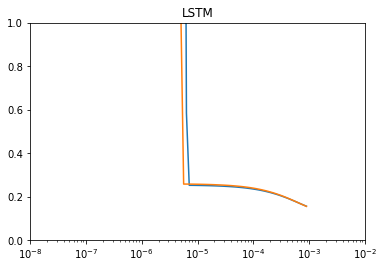

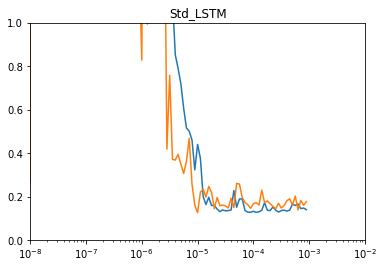

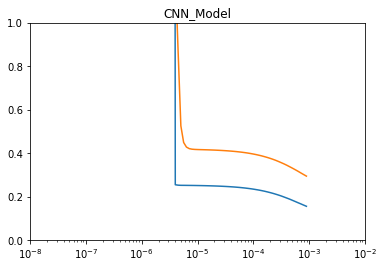

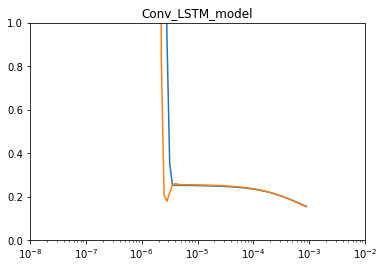

In [273]:
for i, his in enumerate(history):
    pp.figure()
    pp.semilogx(his.history["lr"], his.history["loss"])
    pp.semilogx(his.history["lr"], his.history["val_loss"])
    pp.title(Models[i].name)
    pp.show
    pp.axis([1e-8, 1e-2, 0, 1])

In [279]:
#lr_rates=[3e-6, 3e-7, 3e-6, 2e-6]
lr_rates=[1e-3,1e-3,1e-3,1e-3]

In [283]:
history=[]
# clear session does not seem to work properly - run it without having run the lr scheduler
for i, model in enumerate(Models):
    print(model.summary())
    print("Learning rate:", lr_rates[i])
    trainX=TrainSets[i]
    trainY=OutputSets[i]
    lrate=tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
    optimizer = tf.keras.optimizers.SGD(lr=lr_rates[i], momentum=0.9)
    #optimizer=keras.optimizers.Adam()
    #loss=tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
    #loss=tf.keras.losses.Huber()
    loss="binary_crossentropy"
    #model.compile(loss=loss, optimizer=optimizer, metrics=["mse"])
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    # with validation :#
    #history.append(model.fit(trainX, trainY, epochs=500, validation_split=0.1, callbacks=[lrate,keras.callbacks.TerminateOnNaN()]))
    #without:
    history.append(model.fit(trainX, trainY, epochs=200, callbacks=[keras.callbacks.TerminateOnNaN()]))

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 50)                11600     
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
None
Learning rate: 0.001
Epoch 1/200
Batch 0: Invalid loss, terminating training
 1/11 [=>............................] - ETA: 0s - loss: nan - accuracy: 0.4062Batch 1: Invalid loss, terminating training
Batch 2: Invalid loss, terminating training
Batch 3: Invalid loss, terminating training
Batch 4: Invalid loss, terminating training
Batch 5: Invalid loss, terminating training
Batch 6: Invalid loss, terminating training
Batch 7: Invalid loss, terminating training
 8/11 [====================>.........] - ETA: 0s - 

11/11 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4985
Epoch 124/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 125/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5044
Epoch 126/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4956
Epoch 127/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4956
Epoch 128/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5102
Epoch 129/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5044
Epoch 130/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.4723
Epoch 131/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4752
Epoch 132/200
11/11 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5044
Epoc

11/11 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.5044
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.5044
Epoch 8/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 9/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 10/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 11/200
11/11 [=

11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 165/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 166/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 167/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 168/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.5044
Epoch 169/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 170/200
11/11 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5044
Epoch 171/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 172/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoch 173/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.5044
Epoc

C:\Users\Yves\GOOGLE~1\PROGRA~1\venv_py3\lib\site-packages\ipykernel\pylab\backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


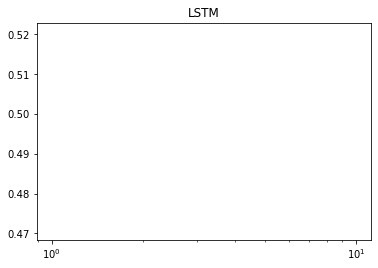

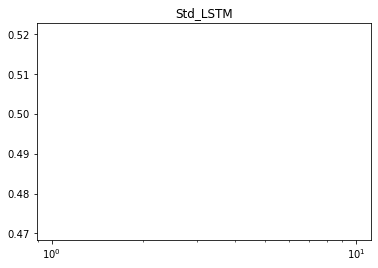

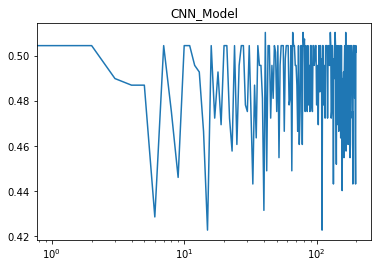

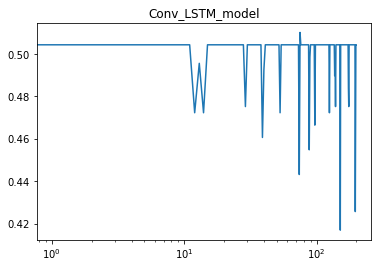

In [285]:
for i, his in enumerate(history):
    pp.figure()
    #pp.semilogx(his.history["lr"],his.history["loss"])
    pp.semilogx(his.history["accuracy"])
    #pp.semilogx(his.history["loss"])
    #pp.semilogx(his.history["lr"],his.history["val_loss"])
    pp.title(Models[i].name)
    pp.show

    #pp.axis([1, 10, 0, 80000])
    #pp.axis([5e-4, 1e-6, 1000, 2000])

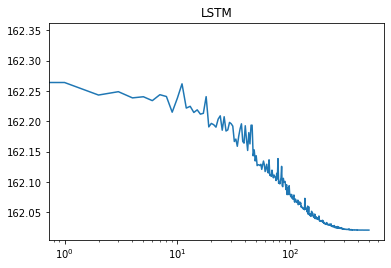

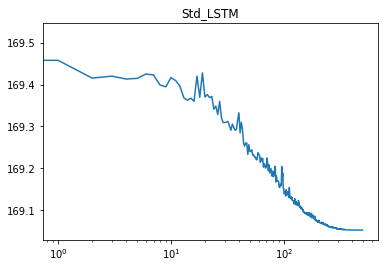

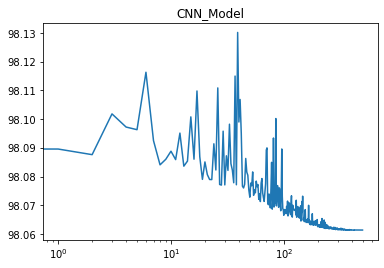

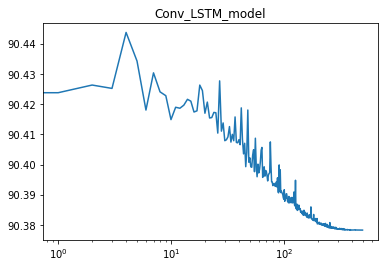

In [181]:
for i, his in enumerate(history):
    pp.figure()
    pp.semilogx(his.history["loss"])
    #pp.semilogx(his.history["val_loss"])
    pp.title(Models[i].name)
    pp.show
    #pp.axis([1e-8, 1e-4, 0, 1000])

In [59]:
Models[0].evaluate(TrainSets[0],OutputSets[0])

10/10 [==============================] - 0s 1ms/step - loss: 7655.6011 - mae: 7656.1011


[7655.60107421875, 7656.10107421875]

In [15]:
############## MULTI STEP PREDICTION ###################
###### Vanilla LSTM - multiple steps prediction - 1 output
def split_sequences_multStep(sequences, n_steps_in, n_steps_out):
    X, y= list(), list()
    for i in range(len(sequences)):
        #find the end of this pattern
        end_ix=i+n_steps_in
        out_end_ix=end_ix+n_steps_out-1
        #check if we are beyon the dataset
        if out_end_ix>len(sequences):
            break
        #gather input and output parts of the pattern
        seq_x, seq_y=sequences[i:end_ix,:-1], sequences[end_ix-1:out_end_ix,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [16]:
n_steps_out=2
X_mult,y_mult= split_sequences_multStep(trainset, n_steps, n_steps_out)
print(X_mult.shape, y_mult.shape)

(342, 14, 7) (342, 2)


In [27]:
n_features=X.shape[2]
Van_multStep_model=Sequential()
Van_multStep_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
Van_multStep_model.add(LSTM(100, activation='relu'))
Van_multStep_model.add(Dense(n_steps_out))
#Van_multStep_model.compile(optimizer='adam', loss='mse')

In [28]:
MultSteps_Models=[Van_multStep_model]
MS_TrainSets=[ X_mult]
MS_ValSets=[ y_mult]

In [29]:
#### FIND LEARNING RATE!!!!!!!!!!!!! #####
######################3################
# find best learning rate for the models!
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-9*10**(epoch/20))
optimizer= tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9)
history=[]
for i, model in enumerate(Models):
    print(model.summary())
    trainX=TrainSets[i]
    trainY=ValSets[i]
    model.compile(loss=tf.keras.losses.Huber(), optimizer="Adam", metrics=["mae"])
    history.append(model.fit(trainX, trainY, epochs=100, callbacks=[lr_schedule]))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                11600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
11/11 [==============================] - 0s 4ms/step - loss: 675.3802 - mae: 675.8800 - lr: 1.0000e-09
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 675.3794 - mae: 675.8793 - lr: 1.1220e-09
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 675.3739 - mae: 675.8738 - lr: 1.2589e-09
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 675.3699 - mae: 675.8698 - lr: 1.4125e-09
Epoch 5/100
11/11 [============================

11/11 [==============================] - 0s 8ms/step - loss: 6329.9370 - mae: 6330.4370 - lr: 2.5119e-08
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 6330.8784 - mae: 6331.3784 - lr: 2.8184e-08
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 6331.2983 - mae: 6331.7983 - lr: 3.1623e-08
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 6330.6665 - mae: 6331.1665 - lr: 3.5481e-08
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 6332.1543 - mae: 6332.6543 - lr: 3.9811e-08
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 6330.5571 - mae: 6331.0571 - lr: 4.4668e-08
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 6332.6104 - mae: 6333.1104 - lr: 5.0119e-08
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 6328.5557 - mae: 6329.0557 - lr: 5.6234e-08
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - l

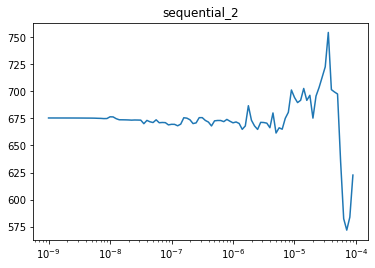

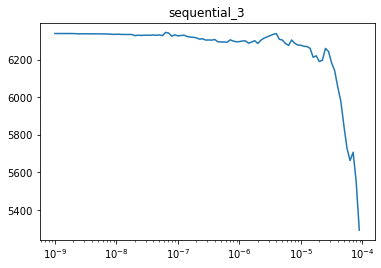

In [30]:
for i, his in enumerate(history):
    pp.figure()
    pp.semilogx(his.history["lr"], his.history["loss"])
    pp.title(Models[i].name)
    pp.show

In [ ]:
lr_rates=[1e-6,1e-6]

when training, look also the cost of test data (not only training data), if it gets worse while cost of
training data gets better, it MIGHT be OVERFITTING

If we see that the accuracy on the test data is no longer improving, then we should stop training. Of course, strictly speaking, this is not necessarily a sign of overfitting. It might be that accuracy on the test data and the training data both stop improving at the same time. Still, adopting this strategy will prevent overfitting.

In general, one of the best ways of reducing overfitting is to increase the size of the training data. With enough training data it is difficult for even a very large network to overfit. 